# Running a circuit on IBM's backends

In the previous section, we discussed running a circuit on your computer using IBM's AerBackend. In practice, running a circuit on an actual device is a little more complicated.

To run circuits on a "real" quantum computer, you need access to machines that are available to the public. You will usually require a cloud application programming interface (cloud API) that allows you to submit and execute circuits remotely. For all these machines, TKET proposes extensions that allow you to execute your circuits directly from `pytket` (you will need an internet connection for this).
The list of these extensions can be found [here](https://github.com/CQCL/pytket-extensions).

The problem is the API in question; for many machines, this is not free. A notable exception is IBM.

## Load your IBM Quantum account and select provider
The Qiskit IBMQ account object is the local reference for accessing your IBM Quantum account, and all of the providers, backends, etc., that are available to you.

The IBM Quantum account has functions for handling administrative tasks. The credentials can be saved to your disk, or used in a session and never saved.

First, create an IBM Quantum account or log in to your existing account by visiting the IBM Quantum login page.([instructions from IBM](https://quantum-computing.ibm.com/docs/manage/account/)) Then copy (and/or optionally regenerate) your API token from your IBM Quantum account page. You can now take your token, here called MY_API_TOKEN, and run:

`from qiskit import IBMQ` 

`IBMQ.save_account('MY_API_TOKEN')`

The command above stores your credentials locally in a configuration file called qiskitrc. By default, this file is located in `HOME/.qiskit` where `HOME` is your home directory. If you are still using Qconfig.py, please delete that file and run the command above.

See more info here: https://github.com/Qiskit/qiskit-ibmq-provider#setting-up-the-ibm-quantum-provider

We will run a circuit on a `pytket` IBMQEmulatorBackend.

In [1]:
from pytket import Circuit
from pytket.extensions.qiskit import IBMQEmulatorBackend
from qiskit import IBMQ
#IBMQ.save_account('MY_API_TOKEN') # Save TOKEN to disk
#IBMQ.load_account() # Load account from disk
#IBMQ.providers()    # List all available providers


Note, you can store your IBM Quantum account information locally ahead of time using `IBMQ.save_account('MY_API_TOKEN')`. MY_API_TOKEN here is the API token you obtain from your IBM Quantum account.

To access a given provider one should use the `get_provider()` method of the IBMQ account, or you can filter by hub, group, or project:
`IBMQ.get_provider(hub='ibm-q')`

`IBMQ.get_provider(group='open')`

Calling `IBMQ.load_account()` will return the default public provider instance <AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>.

With the Free IBM Quantum <AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')> you have access to the several quantum computers with your Open Plan.

To check our code works correctly, we can use the IBMQEmulatorBackend to run our code exactly as if it were going to run on a real device, but just execute on a simulator (with a basic noise model adapted from the reported device properties).


## Create an IBMQEmulatorBackend

Let's create an IBMQEmulatorBackend for the ibmq_belem device and check if our circuit is valid to be run.

In [2]:
import warnings #used to disable warnings in this jupyter notebook, can be omitted 
warnings.filterwarnings('ignore') #used to disable warnings in this jupyter notebook, can be omitted

IBM_backend = IBMQEmulatorBackend('ibmq_belem', hub='ibm-q', group='open', project='main');

In [3]:
# defined a sample circuit
circ3 = Circuit(2, 2)
circ3.Rx(0.3, 0).Ry(0.5, 1).CRz(-0.6, 1, 0)

from pytket.circuit.display import render_circuit_jupyter
circ3.measure_all()
render_circuit_jupyter(circ3)

Just like classical computer architectures have assembly instruction sets that specify CPU computations, quantum computers are typically only able to execute specific operations, called the architecture gate set. Let's see which gates are supported by the ibm_belem emulator. For this, we can use `backend_info.gate_set` to obtain this information on the used gate set.

In [4]:
print(IBM_backend.backend_info.gate_set)

{<OpType.Rz: 33>, <OpType.U3: 34>, <OpType.U2: 35>, <OpType.U1: 36>, <OpType.CX: 39>, <OpType.SX: 28>, <OpType.X: 20>, <OpType.noop: 57>, <OpType.Measure: 58>, <OpType.Reset: 60>}


We can check if the circuit is valid for this backend given the backend gate set.

In [5]:
IBM_backend.valid_circuit(circ3) #check if the circuit is valid

False

We see that we get "false" back. In this specific example, we have an `Rx`, `Ry`, and `Rz` gates. But the ibm_belem emulator only supports the `Rz` gate of these three. Hence we need to compile the circuit to this backend. The compilation of the circuit guarantees the circuit is in a format recognized by the simulator (or quantum computer). For this we use `backend.compile_circuit`.

In [6]:
compiled_circIBM = IBM_backend.get_compiled_circuit(circ3)
render_circuit_jupyter(compiled_circIBM)

In [7]:
IBM_backend.valid_circuit(compiled_circIBM) #check if the circuit is valid

True

After compiling to the ibm_belem gate set, our new circuit is now valid to be run on this emulator. We will run 10 shots and then histogram the counts.

In [8]:
quantum_handle = IBM_backend.process_circuit(compiled_circIBM, n_shots=10)

In [9]:
quantum_shots = IBM_backend.get_result(quantum_handle).get_shots()
print(quantum_shots)

[[0 0]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 0]]


In [10]:
counts = IBM_backend.get_result(quantum_handle).get_counts()
print(counts)

Counter({(0, 1): 5, (0, 0): 3, (1, 0): 2})


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_counts(counts):
    counts_record = [{"State":state, "Count":count} for state, count in counts.items()]
    count_df = pd.DataFrame().from_records(counts_record)
    sns.catplot(x='State', y='Count', kind='bar', data=count_df, aspect = 3, height=2)
    plt.show()

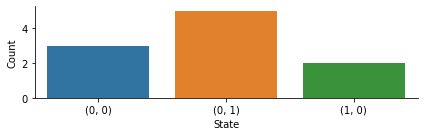

In [12]:
plot_counts(counts)

## Running on the actual device

Being able to run a circuit on a real machine is fun, but it comes with some difficulties. In particular, we must be prepared to stand and wait in a possible long queue before we get your results back from IBM. Let's create a backend for running on the actual device and check that our compiled circuit is also valid for this backend.

In [13]:
from pytket.extensions.qiskit import IBMQBackend

In [14]:
ibmq_b = IBMQBackend("ibmq_belem")  #compile circuit to backend
ibmq_b.valid_circuit(compiled_circIBM) #check if the circuit is valid

True

We are now good to run this circuit on the device. After submitting, we can use the handle to check on the status of the job, so that we know when results are ready to be retrieved. The `circuit_status` method works for all backends, and returns a CircuitStatus object. If we just run get_result straight away, the backend will wait for results to complete, blocking any other code from running.

In [15]:
#quantum_handle_ibmq_b = ibmq_b.process_circuit(compiled_circIBM, n_shots=10)
#print(ibmq_b.circuit_status(quantum_handle_ibmq_b))
#shots = ibmq_b.get_result(quantum_handle_ibmq_b).get_shots()
#print(shots)